## Implement XGBoost - Boosted Trees

### Import necessary files

In [2]:
import pickle ## Import data file
import pandas as pd 
import numpy as np
from numpy import sort ## For sorting feature importances
from matplotlib import pyplot
import xgboost as xgb ## For XGBBoost  model
from sklearn.model_selection import train_test_split ## splitting training dataset for modeling.
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error ## Evaluation metrics.

In [3]:
## Package versions for compliance.
print("Xgboost: {}".format(xgb.__version__))
print("Pandas: {}".format(pd.__version__))
print("Numpy: {}".format(np.__version__))

Xgboost: 1.5.0
Pandas: 1.3.2
Numpy: 1.20.3


In [4]:
##  Load the dataframe from the pickle file.
train = pickle.load(open( "train_data.P", "rb" ))
test = pickle.load(open( "test_data.P", "rb" ))
                    
    
X = train.drop('loan_default', axis = 1)
y = train['loan_default'].astype('int') ## Change Dependent variable back to 'int'.


In [5]:
## Examine 'X' data.
X.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,state_id,employee_code_id,mobileno_avl_flag,...,credit_history_length,no_of_inquiries,total_accts,active_accts,overdue_accts,total_current_balance,total_sanc_amount,total_disbursed_amount,total_instal,age
0,-0.291335,-0.921893,89.55,67,22807,45,1441,6,0.4599,True,...,-0.568639,-0.292449,-0.472558,-0.538021,-0.290192,-0.178324,-0.094714,-0.094368,-0.088154,37
1,-0.555996,-0.544481,73.23,67,22807,45,1502,6,0.4599,True,...,0.236085,-0.292449,-0.283514,-0.034067,1.481510,-0.149597,-0.073657,-0.073337,-0.075084,36
2,-0.083183,-0.765650,89.63,67,22807,45,1497,6,0.4599,True,...,-0.568639,-0.292449,-0.472558,-0.538021,-0.290192,-0.178324,-0.094714,-0.094368,-0.088154,36
3,0.243307,-0.514763,88.48,67,22807,45,1501,6,0.4599,True,...,-0.043819,1.122984,0.094576,-0.538021,-0.290192,-0.178324,-0.094714,-0.094368,-0.087951,27
4,-0.152567,-0.821602,88.39,67,22807,45,1495,6,0.4599,True,...,-0.568639,1.122984,-0.472558,-0.538021,-0.290192,-0.178324,-0.094714,-0.094368,-0.088154,44


In [6]:
## Examine 'y' data.
y.head()

0    0
1    1
2    0
3    1
4    1
Name: loan_default, dtype: int32

In [7]:
## Examine datatypes for categorical columns. Label_encoder will be removed from xgboost so it is best we
## convert columns back to numerical. 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 30 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   disbursed_amount                     233154 non-null  float64 
 1   asset_cost                           233154 non-null  float64 
 2   ltv                                  233154 non-null  float64 
 3   branch_id                            233154 non-null  category
 4   supplier_id                          233154 non-null  category
 5   manufacturer_id                      233154 non-null  category
 6   current_pincode_id                   233154 non-null  category
 7   state_id                             233154 non-null  category
 8   employee_code_id                     233154 non-null  float64 
 9   mobileno_avl_flag                    233154 non-null  bool    
 10  aadhar_flag                          233154 non-null  bool    
 11  

### Use categorical values for label encoding (convert categorical back to integer).

In [8]:
## Select categorical columns.
category_columns = train.select_dtypes(include='category')

## Implement '.cat.codes' to assign values instead of categories.
for column in category_columns:
    X[column] = X[column].cat.codes
    
## Verify Changes   
## X.info()

In [9]:
## create function to convert convert category column into integer with .cat.codes
def cat_conv(data):
## Select categorical columns.
    category_columns = data.select_dtypes(include='category')
## Implement '.cat.codes' to assign values instead of categories.
    for column in category_columns:
        data[column] = data[column].cat.codes
    return

In [10]:
## Convert X and test datasets
cat_conv(X)
cat_conv(test)

### Split data for model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Fit Initial Model

In [31]:
## Set evaulation metrics 
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

In [32]:
## Initialize model using "area under curve" to evaluate quality.
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
                              use_label_encoder=False)

In [33]:
## fit model and set early_stopping_rounds to reduce training time if there is no improvement. 
## Eval set allows us to measure our error when training. 
xgb_model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set, eval_metric=eval_metric)

[0]	validation_0-auc:0.63072	validation_0-error:0.21662	validation_1-auc:0.62325	validation_1-error:0.21810
[1]	validation_0-auc:0.64120	validation_0-error:0.21623	validation_1-auc:0.63267	validation_1-error:0.21800
[2]	validation_0-auc:0.64653	validation_0-error:0.21659	validation_1-auc:0.63588	validation_1-error:0.21814
[3]	validation_0-auc:0.64912	validation_0-error:0.21637	validation_1-auc:0.63794	validation_1-error:0.21774
[4]	validation_0-auc:0.65385	validation_0-error:0.21641	validation_1-auc:0.64053	validation_1-error:0.21776
[5]	validation_0-auc:0.65722	validation_0-error:0.21653	validation_1-auc:0.64263	validation_1-error:0.21814
[6]	validation_0-auc:0.65959	validation_0-error:0.21645	validation_1-auc:0.64326	validation_1-error:0.21805
[7]	validation_0-auc:0.66357	validation_0-error:0.21639	validation_1-auc:0.64561	validation_1-error:0.21807
[8]	validation_0-auc:0.66582	validation_0-error:0.21639	validation_1-auc:0.64693	validation_1-error:0.21802
[9]	validation_0-auc:0.66821

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

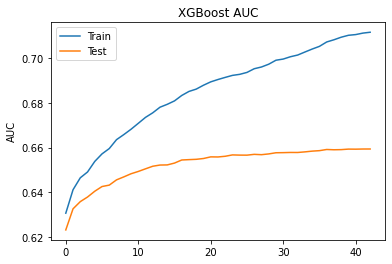

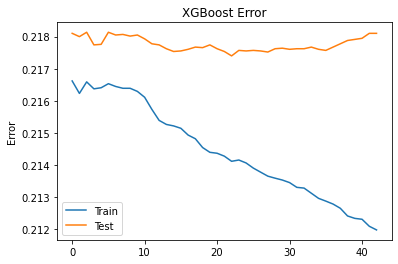

In [56]:
## Assign model results and length of results for X-lim length.
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.title('XGBoost Error')
pyplot.show()


In [16]:
## Predict on model and return initial accuracy.
y_pred = xgb_model.predict(X_test)
print("Initial model accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Initial model accuracy: 78.18%


In [42]:
## Model does not return best parameters, only the final iteration.
## We can return our best scores by using model.best_score, .best_iteration, .best_ntree_limit
print(" Best score: {0}\n Best iteration: {1}\n Best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

 Best score: 0.2174
 Best iteration: 22
 Best ntree limit 23


### Feature Importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

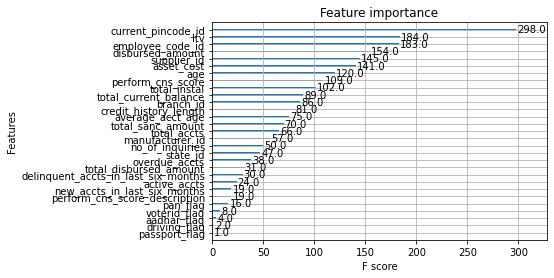

In [60]:
## Visualize feature importances for initial model.
xgb.plot_importance(xgb_model)

In [61]:
## Sort feature importances into variable and loop through features, reducing the number of features one at a time by
## increasing the threshold. For each feature removed we fit a model, predict on model and return the accuracy with 
## specified threshold and feature number(n).

thresholds = sort(xgb_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc",
                                       use_label_encoder=False)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=30, Accuracy: 78.17%
Thresh=0.016, n=29, Accuracy: 78.17%
Thresh=0.018, n=28, Accuracy: 78.18%
Thresh=0.018, n=27, Accuracy: 78.13%
Thresh=0.019, n=26, Accuracy: 78.15%
Thresh=0.020, n=25, Accuracy: 78.15%
Thresh=0.021, n=24, Accuracy: 78.09%
Thresh=0.021, n=23, Accuracy: 78.18%
Thresh=0.022, n=22, Accuracy: 78.15%
Thresh=0.022, n=21, Accuracy: 78.14%
Thresh=0.023, n=20, Accuracy: 78.11%
Thresh=0.025, n=19, Accuracy: 78.17%
Thresh=0.027, n=18, Accuracy: 78.16%
Thresh=0.029, n=17, Accuracy: 78.22%
Thresh=0.029, n=16, Accuracy: 78.13%
Thresh=0.030, n=15, Accuracy: 78.17%
Thresh=0.032, n=14, Accuracy: 78.17%
Thresh=0.033, n=13, Accuracy: 78.18%
Thresh=0.038, n=12, Accuracy: 78.15%
Thresh=0.039, n=11, Accuracy: 78.13%
Thresh=0.039, n=10, Accuracy: 78.12%
Thresh=0.042, n=9, Accuracy: 78.19%
Thresh=0.043, n=8, Accuracy: 78.15%
Thresh=0.045, n=7, Accuracy: 78.13%
Thresh=0.046, n=6, Accuracy: 78.14%
Thresh=0.047, n=5, Accuracy: 78.12%
Thresh=0.049, n=4, Accuracy: 78.17%
Thresh=

* It appears that removing any features will not return any significant increase in accuracy. So we will keep all the current features for the final model. 

### Hyperopt parameter tuning

* Hyperopt is a python library for hyperparameter optimization that uses a form of Bayesian optimization that allows you to get the best parameters for a give model.

* The approach of Bayesian Optimization focuses on a probability model P(score| configuration), which is updated through an iterative process of querying a history “H” of (score, configuration) whose objective is the maximization of the score given a configuration “c”. 

In [62]:
## Install hyperopt: "conda install -c conda-forge hyperopt"

## Import necessary items from hyperopt packages.
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [63]:
## Specify hyperopt parameters 
## hp. quniform(label, low, high, q) Returns a value like round(uniform(low, high) / q) * q

space={ 'max_depth': hp.quniform("max_depth", 1, 20, 1), ## How deep trees nodes can go. 
        'gamma': hp.uniform ('gamma',0,9), ## Minimum loss reduction to create a new split.
        'reg_alpha' : hp.quniform('reg_alpha', 10,180,1), ## L1 reg on leaf weights.
        'reg_lambda' : hp.uniform('reg_lambda', 0,1), ## L2 reg leaf weights.
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.001,1), ##  Fraction of the features that can be used to train each tree.
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1), ## Minimum sum of instance weight (hessian) needed in a child.
        'learning_rate':  hp.quniform('learning_rate', 0, 0.5, .1), ## How quickly the model fits residual errors. 
        'subsample': 1, ## Fraction of training set to train each tree.
        'n_estimators': 100
    }

In [64]:
## define function to setup classifier, evalution, fit the model, predict on model and return accuracy.
## SCORE is printed for each model to visualize progression. 
##
def objective(space):
    clf=xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False,
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)*100
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [65]:
## Run hyperopt optimization. 
trials = Trials()

## Fit best parameters into variable.
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
78.189709893805                                        
SCORE:                                                                         
78.189709893805                                                                
SCORE:                                                                         
78.189709893805                                                                
SCORE:                                                                         
78.189709893805                                                                
SCORE:                                                                         
78.189709893805                                                                
SCORE:                                                                         
78.189709893805                                                                
SCORE:                                                                         
78.18799

SCORE:                                                                            
78.189709893805                                                                   
100%|██████████| 100/100 [07:42<00:00,  4.62s/trial, best loss: -78.22059050592736]


In [68]:
## Print best parameters.
print("The best hyperparameters are: ")
print(best_hyperparams)

The best hyperparameters are: 
{'colsample_bytree': 0.5435127826496389, 'gamma': 6.700837383199838, 'learning_rate': 0.4, 'max_depth': 8.0, 'min_child_weight': 6.0, 'reg_alpha': 11.0, 'reg_lambda': 0.7666759032845739}


### Final Model

In [69]:
## Fit model with best parameters from hyperopt.
final_model = xgb.XGBClassifier(objective="binary:logistic",
                                use_label_encoder = False,
                              colsample_bytree = 0.5435127826496389,
                              gamma = 6.700837383199838,
                              learning_rate= 0.4,
                              max_depth = 8,
                              min_child_weight = 6.0,
                              reg_alpha = 11,
                              reg_lambda =  0.7666759032845739)

In [70]:
eval_set2 = [(X_train, y_train), (X_test, y_test)]
eval_metric2 = ["auc","error"]

## Train final model
final_model.fit(X_train, y_train, early_stopping_rounds=20,
                eval_set=eval_set2, eval_metric=eval_metric2)

[0]	validation_0-auc:0.60157	validation_0-error:0.21640	validation_1-auc:0.59282	validation_1-error:0.21786
[1]	validation_0-auc:0.63453	validation_0-error:0.21632	validation_1-auc:0.62589	validation_1-error:0.21773
[2]	validation_0-auc:0.64540	validation_0-error:0.21635	validation_1-auc:0.63552	validation_1-error:0.21786
[3]	validation_0-auc:0.65221	validation_0-error:0.21622	validation_1-auc:0.64019	validation_1-error:0.21785
[4]	validation_0-auc:0.65651	validation_0-error:0.21621	validation_1-auc:0.64367	validation_1-error:0.21783
[5]	validation_0-auc:0.66070	validation_0-error:0.21612	validation_1-auc:0.64746	validation_1-error:0.21776
[6]	validation_0-auc:0.66278	validation_0-error:0.21601	validation_1-auc:0.64927	validation_1-error:0.21764
[7]	validation_0-auc:0.66480	validation_0-error:0.21594	validation_1-auc:0.65078	validation_1-error:0.21766
[8]	validation_0-auc:0.66724	validation_0-error:0.21590	validation_1-auc:0.65282	validation_1-error:0.21773
[9]	validation_0-auc:0.66802

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5435127826496389,
              enable_categorical=False, gamma=6.700837383199838, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=8,
              min_child_weight=6.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=11,
              reg_lambda=0.7666759032845739, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

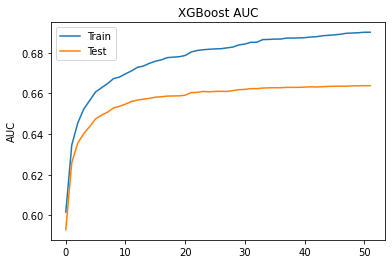

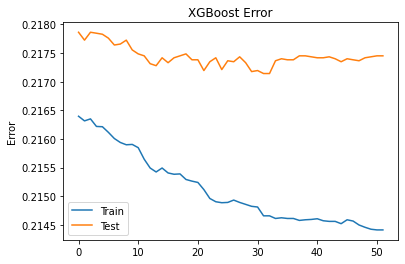

In [71]:
## Assign model results and length of results for X-lim length.
results = final_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.title('XGBoost Error')
pyplot.show()


In [72]:
## Predit on final model and display accuracy score.
y_pred2 = final_model.predict(X_test)
print("Final model accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred2)*100))

Final model accuracy: 78.29%


In [73]:
## XGBBoost model only returns final score, not best parameters.
## Print best score and parameters, which also happens to be final iteration.
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(final_model.best_score, final_model.best_iteration, final_model.best_ntree_limit))

best score: 0.217142, best iteration: 31, best ntree limit 32


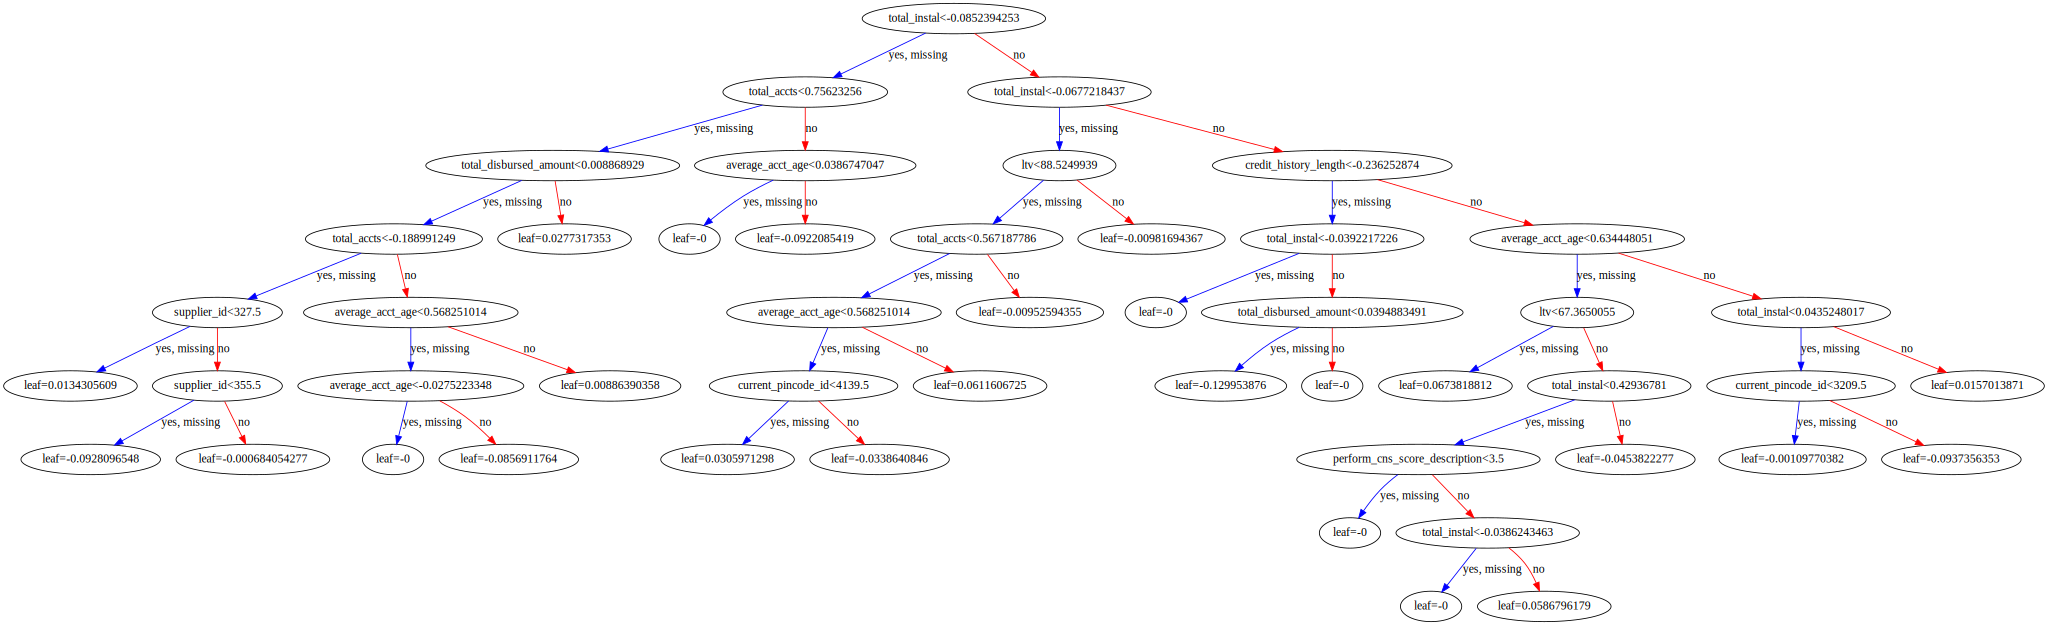

In [74]:
## Vizualize final tree.
xgb.to_graphviz(final_model, num_trees=final_model.best_iteration)

### Test Dataset Predictions

In [82]:
finalpredictions = final_model.predict(test)

In [83]:
predicted_values=pd.DataFrame(finalpredictions)

In [84]:
predicted_values.value_counts()

0    111839
1       553
dtype: int64

* Final predictions show that only 553 people in the dataset have or will default on their loans. 

In [78]:
predictions = xgb_model.predict(test)

In [79]:
rv = pd.DataFrame(predictions)

In [80]:
rv.value_counts()

0    112100
1       292
dtype: int64